https://www.wnyc.org/story/bronx-has-least-internet-connectivity-city/

In [1]:
import io
import os
import pandas as pd
import geopandas as gpd
import numpy as np

import urllib
import requests

import shapely
from fiona.crs import from_epsg

import json

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
os.getenv("PUIDATA")

'/nfshome/jl9200/PUIdata'

1. Download PUMA DATA

In [3]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url,"file.gz")
! unzip -d $PUIDATA/pumadata file.gz

Archive:  file.gz
  inflating: /nfshome/jl9200/PUIdata/pumadata/geo_export_cd1cd14e-6e2a-449a-b468-502a6d6574b5.dbf  
  inflating: /nfshome/jl9200/PUIdata/pumadata/geo_export_cd1cd14e-6e2a-449a-b468-502a6d6574b5.shp  
  inflating: /nfshome/jl9200/PUIdata/pumadata/geo_export_cd1cd14e-6e2a-449a-b468-502a6d6574b5.shx  
  inflating: /nfshome/jl9200/PUIdata/pumadata/geo_export_cd1cd14e-6e2a-449a-b468-502a6d6574b5.prj  


In [4]:
directory = os.getenv("PUIDATA")+"/pumadata"
pumashp = gpd.GeoDataFrame.from_file(directory)

In [5]:
# check the crs
pumashp.crs

{'init': 'epsg:4326'}

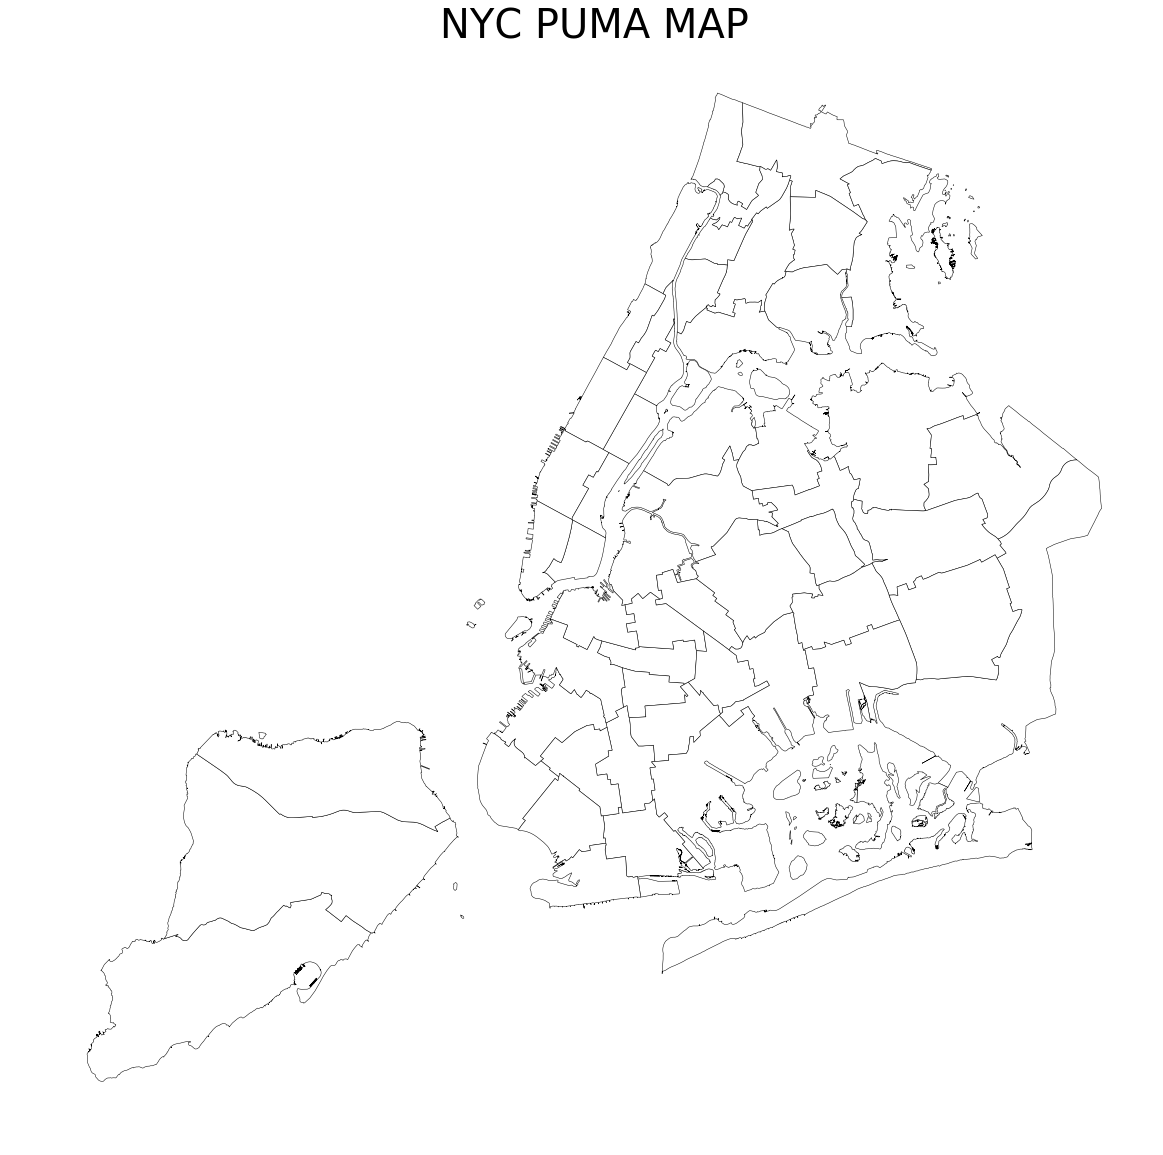

In [6]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
pumashp.plot(ax = ax,color = 'w',edgecolor = 'black',lw = 0.5)
ax.axis('off')
plt.title(r"NYC PUMA MAP",fontsize = 40)
plt.show()


Figure 1:  PUMA BOUNDARY OF NEW YORK CITY 

In [7]:
#### download census data

#### download linkNYC data

In [8]:
# data from (https://data.cityofnewyork.us/City-Government/NYC-Wi-Fi-Hotspot-Locations/yjub-udmw)

%time wifidata = pd.read_csv("https://data.cityofnewyork.us/api/views/yjub-udmw/rows.csv?accessType=DOWNLOAD",parse_dates=True)
wifidata.shape


CPU times: user 60 ms, sys: 8 ms, total: 68 ms
Wall time: 558 ms


(3205, 29)

In [9]:
# check null
wifidata.isnull().sum()

OBJECTID                   0
Borough                    0
Type                       0
Provider                   0
Name                     258
Location                   0
Latitude                   0
Longitude                  0
X                          0
Y                          0
Location_T                 0
Remarks                  571
City                       0
SSID                       0
SourceID                1089
Activated               1462
BoroCode                   0
BoroName                   0
NTACode                    0
NTAName                    0
CounDist                   0
Postcode                   0
BoroCD                     0
CT2010                     0
BCTCB2010                  0
BIN                        0
BBL                        0
DOITT_ID                   0
Location (Lat, Long)       0
dtype: int64

In [10]:
# df.dropna(subset = ['col1','col2],inplace = True)
# wifidata.dropna(subset = ['Latitude','Longitude'],inplace = True)

In [11]:
wifidata.head()

OBJECTID Borough  Type          Provider  \
0      8641      QU  Free  Spot On Networks   
1      8642      QU  Free  Spot On Networks   
2      8643      QU  Free  Spot On Networks   
3      8644      QU  Free  Spot On Networks   
4      8645      QU  Free  Spot On Networks   

                                             Name         Location   Latitude  \
0  QUEENS BRIDGE - JACOB A. RIIS Settlement House  10-25 41 AVENUE  40.755727   
1  QUEENS BRIDGE - JACOB A. RIIS Settlement House  10-43 41 AVENUE  40.755333   
2  QUEENS BRIDGE - JACOB A. RIIS Settlement House  10-05 41 AVENUE  40.755751   
3  QUEENS BRIDGE - JACOB A. RIIS Settlement House  10-05 41 AVENUE  40.755751   
4  QUEENS BRIDGE - JACOB A. RIIS Settlement House  10-05 41 AVENUE  40.755751   

   Longitude              X              Y  \
0 -73.944583  999603.226171  214613.274563   
1 -73.944131  999728.543834  214469.807003   
2 -73.945166  999441.701232  214621.916935   
3 -73.945166  999441.701232  214621.916935   
4 -73.945166  999441.701232  214621.916935   

                     ...                      \
0                    ...                       
1                    ...                       
2                    ...                       
3                    ...                       
4                    ...                       

                                    NTAName CounDist Postcode BoroCD CT2010  \
0  Queensbridge-Ravenswood-Long Island City       26    11101    401     25   
1  Queensbridge-Ravenswood-Long Island City       26    11101    401     25   
2  Queensbridge-Ravenswood-Long Island City       26    11101    401     25   
3  Queensbridge-Ravenswood-Long Island City       26    11101    401     25   
4  Queensbridge-Ravenswood-Long Island City       26    11101    401     25   

  BCTCB2010      BIN         BBL DOITT_ID  \
0   4002500  4433386  4004700100     4746   
1   4002500  4433386  4004700100     4747   
2   4002500  4433386  4004700100     4748   
3   4002500  4433386  4004700100     4749   
4   4002500  4433386  4004700100     4750   

                        Location (Lat, Long)  
0  Queens\n(40.75572700000, -73.94458300000)  
1  Queens\n(40.75533300000, -73.94413100000)  
2  Queens\n(40.75575100000, -73.94516600000)  
3  Queens\n(40.75575100000, -73.94516600000)  
4  Queens\n(40.75575100000, -73.94516600000)  

[5 rows x 29 columns]

In [12]:
wifidata.Provider = wifidata.Provider.astype(str)
wifidata.Longitude = wifidata.Longitude.astype(float)
wifidata.Latitude = wifidata.Latitude.astype(float)
wifidata.Type = wifidata.Type.astype(str)

In [13]:
print(wifidata.Type.unique())

['Free' 'Limited Free' 'Partner Site']


** We choose the wifi which is free or limited free **

In [14]:
wifidata2 = wifidata[wifidata['Type']!='Partner Site']

In [15]:
# combine lat and lon
wifidata2['lonlat'] = list(zip(wifidata2.Longitude,wifidata2.Latitude))
# use shapely.geometry.Point
wifidata2['geometry'] = wifidata2[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
wifidata2['IsLinkNYC'] = wifidata2.Provider.str.contains('LinkNYC')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
# just check number of the linkNYC spots
len(wifidata2[wifidata2.IsLinkNYC==True])

1731

In [18]:
linkNYC = pd.read_csv("https://data.cityofnewyork.us/api/views/3ktt-gd74/rows.csv?accessType=DOWNLOAD&bom=true&query=select+*")

In [19]:
###

In [20]:
wifidata2 = gpd.GeoDataFrame(wifidata2)

In [21]:
wifidata2.to_crs = from_epsg(4326)

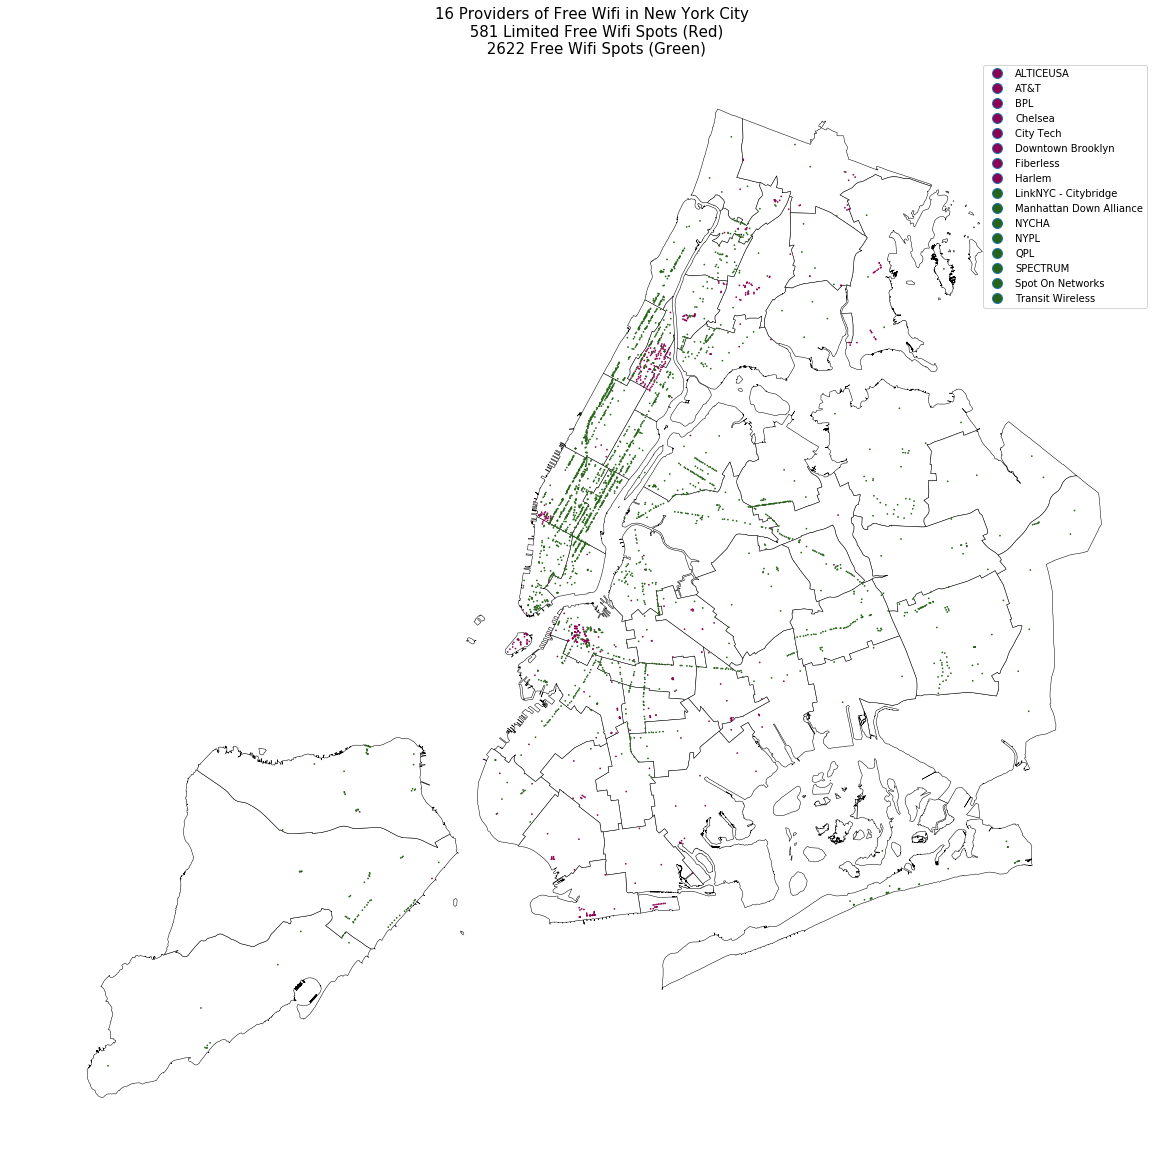

In [24]:

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)

# get 2 discrete color 
cmap2 = plt.get_cmap('PiYG', 2) 
pumashp.plot(ax = ax,color = 'w',edgecolor = 'black',lw = 0.5)
wifidata2.plot(ax = ax, column = 'Provider',markersize = 0.5,marker = 'o',cmap = cmap2,legend = True)
ax.axis('off')
legendtitle = '{} Providers of Free Wifi in New York City \n {} Limited Free Wifi Spots (Red)\n {} Free Wifi Spots (Green)'\
.format(len(wifidata2.Provider.unique()),
        len(wifidata2[wifidata2.Type == 'Limited Free'].index),
        len(wifidata2[wifidata2.Type == 'Free'].index))
plt.title(legendtitle, fontsize  = 15)
plt.show()








Figure 2:  WIFI SPOTS PROVIDERS IN NEW YORK CITY

In [25]:
# load the ACS 1yr data from json
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET',url)
aff1y = json.loads(resp.text)

In [26]:
affkeys = np.array(list(aff1y['variables'].keys()))
len(affkeys)

31710

In [27]:
# extract variables of B28002 which is relate to internet accessibility
[(k,aff1y['variables'][k]['label']) for k in affkeys if k.startswith('B28002')]

[('B28002_002E', 'Estimate!!Total!!With an Internet subscription'),
 ('B28002_001E', 'Estimate!!Total'),
 ('B28002_003E',
  'Estimate!!Total!!With an Internet subscription!!Dial-up with no other type of Internet subscription'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_005E',
  'Estimate!!Total!!With an Internet subscription!!Cellular data plan'),
 ('B28002_013E', 'Estimate!!Total!!No Internet access'),
 ('B28002_010E',
  'Estimate!!Total!!With an Internet subscription!!Satellite Internet service!!Satellite Internet service with no other type of Internet subscription'),
 ('B28002_006E',
  'Estimate!!Total!!With an Internet subscription!!Cellular data plan!!Cellular data plan with no other type of Internet subscription'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B

In [28]:
# now we need to chose the neighborhood without internet access
# B28002_013E with no internet access
NoKey = 'B28002_013E'
aff1y['variables'][NoKey]


{'attributes': 'B28002_013M,B28002_013EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!No Internet access',
 'limit': 0,
 'predicateType': 'int'}

In [29]:
# keyword for the number of households

keyhouseholds = 'B28002_001E'
aff1y['variables'][keyhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [30]:
# get the household with no internet access
from censusAPI import myAPI
url2 = 'https://api.census.gov/data/2016/acs/acs1?get=' + NoKey +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp2 = requests.request('GET',url2)
HH_noint = pd.read_csv(io.StringIO(resp2.content.decode('utf-8').replace('[','').replace(']','')))
HH_noint.head()

B28002_013E                                               NAME  state  \
0         6683                 St. Lawrence County PUMA, New York     36   
1        12934  Clinton, Franklin, Essex & Hamilton Counties P...     36   
2         8484        Warren & Washington Counties PUMA, New York     36   
3         6456  Herkimer (North & Central) & Oneida (Outer) Co...     36   
4        10668  Oneida County (Central)--Greater Utica & Rome ...     36   

   public use microdata area  Unnamed: 4  
0                        100         NaN  
1                        200         NaN  
2                        300         NaN  
3                        401         NaN  
4                        402         NaN

In [31]:
# getting the first row of the table: the total number of households
url3 = "https://api.census.gov/data/2016/acs/acs1?get=" + keyhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI

resp3 = requests.request('GET',url3)
pumaPP = pd.read_csv(io.StringIO(resp3.content.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head()

B28002_001E                                               NAME  state  \
0        40479                 St. Lawrence County PUMA, New York     36   
1        67092  Clinton, Franklin, Essex & Hamilton Counties P...     36   
2        51614        Warren & Washington Counties PUMA, New York     36   
3        44300  Herkimer (North & Central) & Oneida (Outer) Co...     36   
4        61146  Oneida County (Central)--Greater Utica & Rome ...     36   

   public use microdata area  Unnamed: 4  
0                        100         NaN  
1                        200         NaN  
2                        300         NaN  
3                        401         NaN  
4                        402         NaN

In [32]:
pumaPP = pumaPP.merge(HH_noint)
pumaPP['NoInt'] = round(pumaPP['B28002_013E']/pumaPP['B28002_001E'],4)*100
pumaPP.drop(['Unnamed: 4'],axis =1,inplace = True)


In [33]:
pumaPP.columns = ["TotalHousehold","Name","State","puma","TotalHouseholdNoInt","pcNoInt"]
pumaPP.puma = pumaPP.puma.astype(int)

In [34]:
pumashp.puma = pumashp.puma.astype(int)

In [35]:
pumashp2 = pumashp.merge(pumaPP, on = "puma")

In [36]:
pumashp2.head()

puma    shape_area     shape_leng  \
0  3701  9.792852e+07   53227.144461   
1  3702  1.889860e+08  106050.002302   
2  3703  2.670137e+08  304071.257466   
3  3704  1.062129e+08   47970.901277   
4  4015  8.105438e+07   50007.415493   

                                            geometry  TotalHousehold  \
0  POLYGON ((-73.89641133483133 40.90450452082026...           42158   
1  POLYGON ((-73.8442314689986 40.86942035096838,...           49817   
2  (POLYGON ((-73.78833349834532 40.8346671297593...           44329   
3  POLYGON ((-73.84792614069238 40.8713422330779,...           44476   
4  POLYGON ((-73.95374853778468 40.63858633758547...           55953   

                                                Name  State  \
0  NYC-Bronx Community District 8--Riverdale, Fie...     36   
1  NYC-Bronx Community District 12--Wakefield, Wi...     36   
2  NYC-Bronx Community District 10--Co-op City, P...     36   
3  NYC-Bronx Community District 11--Pelham Parkwa...     36   
4  NYC-Brooklyn Community District 14--Flatbush &...     36   

   TotalHouseholdNoInt  pcNoInt  
0                 5771    13.69  
1                 9447    18.96  
2                 5835    13.16  
3                 8569    19.27  
4                10199    18.23

In [37]:
# see the top 10 with high presentage of no Internet access families
pumashp2.sort_values(by = ['pcNoInt'],ascending = False)[:10]

puma    shape_area     shape_leng  \
24  3809  4.869347e+07   35299.804402   
17  4014  8.768042e+07   51089.073159   
12  3710  1.377966e+08   91086.012338   
6   3705  1.224951e+08   68657.316149   
8   3707  4.228113e+07   37347.925798   
34  4007  7.220681e+07   44862.448657   
10  3708  5.589695e+07   34852.437966   
29  4001  1.149292e+08   74076.375782   
19  3804  6.461212e+07   62599.500502   
42  4103  3.298601e+08  144145.949178   

                                             geometry  TotalHousehold  \
24  (POLYGON ((-73.98237340572007 40.7055433504376...           76131   
17  POLYGON ((-73.9781907435932 40.64752599151113,...           42114   
12  (POLYGON ((-73.89680883223774 40.7958084451597...           52756   
6   POLYGON ((-73.87359713633828 40.83979855593596...           58706   
8   POLYGON ((-73.89735765412577 40.8587627349268,...           46654   
34  POLYGON ((-73.92281106533045 40.6670717607133,...           42579   
10  POLYGON ((-73.91046008330409 40.84279164297445...           50192   
29  POLYGON ((-73.96736391699473 40.71648367905524...           66037   
19  (POLYGON ((-73.92133752419279 40.8008521075021...           51915   
42  (POLYGON ((-73.86788407404643 40.7873610366938...           84004   

                                                 Name  State  \
24  NYC-Manhattan Community District 3--Chinatown ...     36   
17  NYC-Brooklyn Community District 12--Borough Pa...     36   
12  NYC-Bronx Community District 1 & 2--Hunts Poin...     36   
6   NYC-Bronx Community District 3 & 6--Belmont, C...     36   
8   NYC-Bronx Community District 5--Morris Heights...     36   
34  NYC-Brooklyn Community District 16--Brownsvill...     36   
10  NYC-Bronx Community District 4--Concourse, Hig...     36   
29  NYC-Brooklyn Community District 1--Greenpoint ...     36   
19  NYC-Manhattan Community District 11--East Harl...     36   
42  NYC-Queens Community District 7--Flushing, Mur...     36   

    TotalHouseholdNoInt  pcNoInt  
24                23686    31.11  
17                13054    31.00  
12                15186    28.79  
6                 16181    27.56  
8                 12643    27.10  
34                11087    26.04  
10                12461    24.83  
29                15796    23.92  
19                12121    23.35  
42                19181    22.83

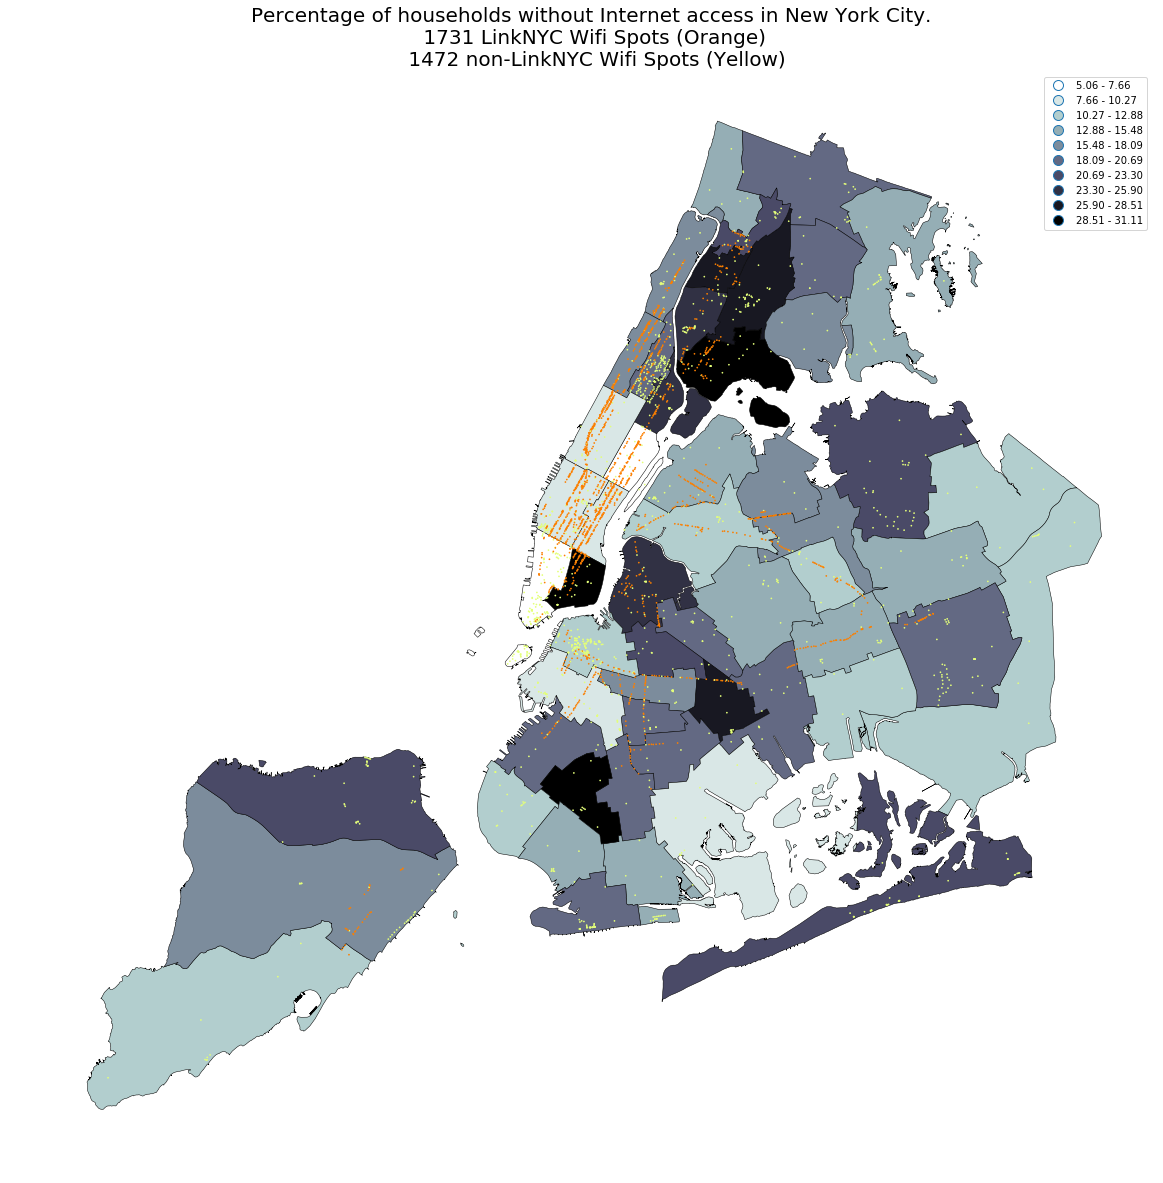

In [38]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
cmap3 = plt.get_cmap('Wistia',2)
pumashp2.plot(ax = ax,column = 'pcNoInt', cmap = 'bone_r',scheme = 'Equal_interval', k =10, edgecolor = 'black',lw = 0.5,legend = True)
wifidata2.plot(ax = ax,column = 'IsLinkNYC',markersize = 0.5,marker = 'o',cmap = cmap3)
ax.axis('off')

title = 'Percentage of households without Internet access in New York City. \n {} LinkNYC Wifi Spots (Orange) \n {} non-LinkNYC Wifi Spots (Yellow)'\
.format(len(wifidata2[wifidata2.IsLinkNYC==True]),len(wifidata2[wifidata2.IsLinkNYC==False]))

plt.title(title,fontsize = 20)
plt.show()

Figure 3: LINKNYC WIFI VS NON-LINKNYC WIFI ON TOP OF HOUSEHOLDS WITH NO INTERNECT ACCESS PERCENTAGE IN NYC **

In [ ]:
# download dataset of sidewalk coffee

# sidewalkcoffee = pd.read_csv("https://www1.nyc.gov/assets/dca/downloads/datasets/SWC.CSV")